Data loading took 0.03 seconds.
Feature preprocessing took 0.01 seconds.
SVM-RBF training took 2.16 seconds.

Model saved to /Users/mariaprosgaznares/Desktop/Birdify/models/SVM-RBF_model.pkl

Model package saved to /Users/mariaprosgaznares/Desktop/Birdify/models/svm_model_package.pkl

Evaluating SVM-RBF Model:

Evaluation Metrics Summary:
Accuracy: 0.8653
Balanced Accuracy: 0.8653
Matthews Correlation: 0.8629
Cohen's Kappa: 0.8626
AUC (OvR): 0.9950
AUC (OvO): 0.9950
Weighted Avg F1: 0.8618
Macro Avg F1: 0.8618

Detailed Classification Report:
                            precision    recall  f1-score   support

               Andean Guan       0.72      0.60      0.65        30
          Band-tailed Guan       0.61      0.67      0.63        30
            Barred Tinamou       0.91      1.00      0.95        30
        Bartlett's Tinamou       0.77      0.77      0.77        30
                Baudo Guan       1.00      1.00      1.00        30
              Bearded Guan       0.79     

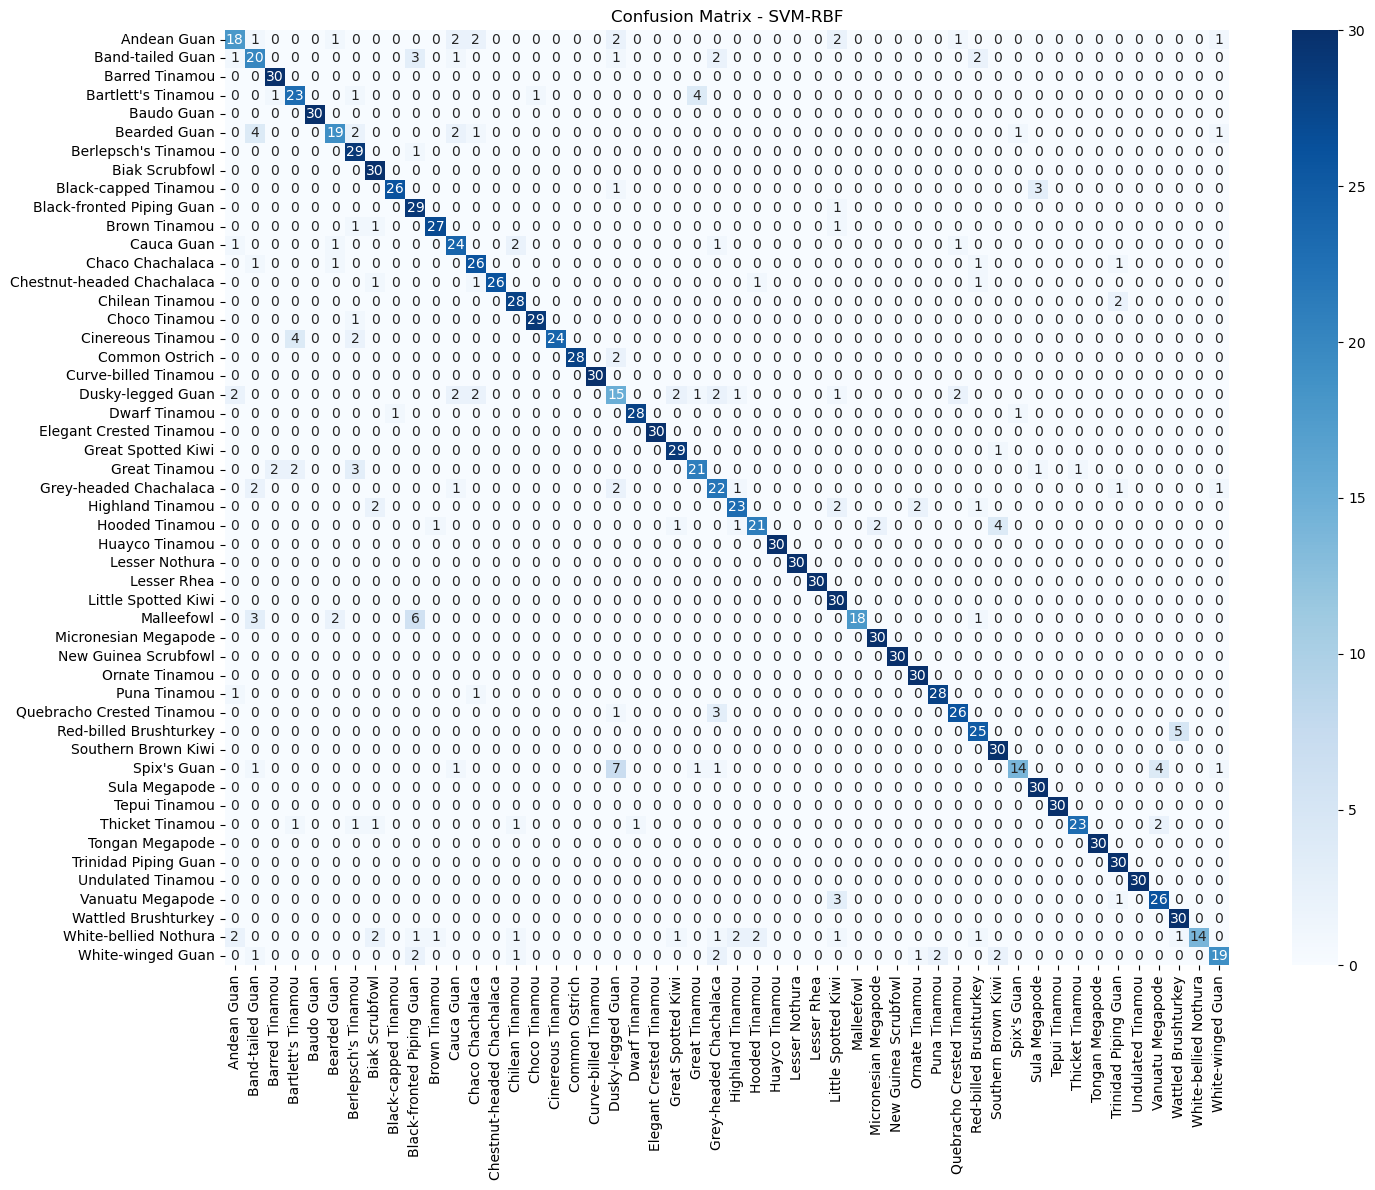

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            precision_recall_fscore_support, accuracy_score,
                            balanced_accuracy_score, matthews_corrcoef,
                            cohen_kappa_score)
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import json
import os

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
FEATURES_DIR = DATA_DIR / 'features/selected_feature_TOP50/selected_features.csv'
MODEL_DIR = BASE_DIR / 'models'
METRICS_DIR = BASE_DIR / 'metrics'

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# timing helper
def print_time(label, start_time):
    print(f"{label} took {time.time() - start_time:.2f} seconds.")

def evaluate_model_svm(clf, X_test, y_test, label_encoder):
    """Enhanced evaluation function with comprehensive metrics for SVM"""
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    # Convert to one-hot for multiclass metrics
    y_onehot = np.zeros((y_test.size, y_test.max()+1))
    y_onehot[np.arange(y_test.size), y_test] = 1
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_test, y_pred),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred),
        'auc_ovr': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovr'),
        'auc_ovo': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovo'),
    }
    
    # Add per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    metrics['per_class'] = {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    
    # Weighted and macro averages
    metrics['weighted_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
    }
    
    metrics['macro_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='macro')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='macro')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
    }
    
    # Save metrics to JSON file
    metrics_file = METRICS_DIR / 'evaluation_metrics_SVM.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Print summary metrics
    print("\nEvaluation Metrics Summary:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"Matthews Correlation: {metrics['matthews_corrcoef']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print(f"AUC (OvR): {metrics['auc_ovr']:.4f}")
    print(f"AUC (OvO): {metrics['auc_ovo']:.4f}")
    print(f"Weighted Avg F1: {metrics['weighted_avg']['f1']:.4f}")
    print(f"Macro Avg F1: {metrics['macro_avg']['f1']:.4f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title("Confusion Matrix - SVM-RBF")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'confusion_matrix_SVM.png', dpi=300)
    plt.show()
    
    return metrics

if __name__ == "__main__":
    # Load the extracted features CSV
    start = time.time()
    features_df = pd.read_csv(FEATURES_DIR)
    print_time("Data loading", start)

    # Drop non-feature columns
    start = time.time()
    non_feature_cols = ['species', 'call_type', 'filename']
    X = features_df.drop(columns=non_feature_cols)
    y = features_df['species']

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print_time("Feature preprocessing", start)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, 
        test_size=0.3, 
        random_state=42, 
        stratify=y_encoded
    )

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_encoded), 
        y=y_encoded
    )
    class_weights = dict(enumerate(class_weights))

    # Train SVM-RBF with probability estimates
    start = time.time()
    clf = SVC(
        kernel='rbf', 
        probability=True, 
        random_state=42,
        class_weight=class_weights
    )
    clf.fit(X_train, y_train)
    print_time("SVM-RBF training", start)

    # Save the trained model
    model_file = MODEL_DIR / 'SVM-RBF_model.pkl'
    import joblib
    joblib.dump(clf, model_file)
    print(f"\nModel saved to {model_file}")
    # Save the trained model AND label encoder
    joblib.dump({
        'model': clf,
        'label_encoder': label_encoder,
        'scaler': scaler  # Optional: Include if you need scaling in app.py
    }, MODEL_DIR / 'svm_model_package.pkl')  # Single package file

    print(f"\nModel package saved to {MODEL_DIR / 'svm_model_package.pkl'}")
    

    # Evaluate with comprehensive metrics
    print("\nEvaluating SVM-RBF Model:")
    metrics = evaluate_model_svm(clf, X_test, y_test, label_encoder)